In [3]:
import sys

# setting path
sys.path.append('..')

import numpy as np
import time

from src.models.bocs.LinReg import LinReg
from src.models.GPr import GPr
from ngboost import NGBRegressor
from ngboost.distns import LogNormal, Normal, Exponential
from ngboost.scores import CRPS, LogScore
from xgboost import XGBRegressor

# Learners
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from src.problems.contamination import Contamination
from src.problems.rna import RNA
from src.problems.bqp import BQP
from src.problems.latin_square import LatinSquare

from src.sbbo_mh import MHSBBO

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from src.uncertainty_metrics import *


# Convergence

In [9]:
N = 300
opt_prob = Contamination(n=N, lamda=0.0001)

In [11]:
params = {}
params["cooling_schedule"] = np.arange(50, 5000, 100)
params["burnin"] = 0.8
params["modal"]  = False
params["af"] = "EI"

learner = GPr()
params["model"] = learner

search = MHSBBO(opt_prob, params)

df = search.compute_trace()

Percentage completed: 0.0
Current quality 0.00012004892231025714
Percentage completed: 2.0
Current quality 0.00010000000000000003
Percentage completed: 4.0
Current quality 0.00010000000000000003
Percentage completed: 6.0
Current quality 0.00010530686527180094
Percentage completed: 8.0
Current quality 0.0002159919338538509
Percentage completed: 10.0
Current quality 0.000354004476780882
Percentage completed: 12.0
Current quality 0.015315916208123205
Percentage completed: 14.0
Current quality 0.03298491430981363
Percentage completed: 16.0
Current quality 0.038340892577500306
Percentage completed: 18.0
Current quality 0.08730819770134113


/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/sbbo/notebooks/../src/sbbo_mh.py:70: RuntimeWarning: overflow encountered in exp
  prob =  np.exp(H*value - H*value_old)


Percentage completed: 20.0
Current quality 0.1640914816210057
Percentage completed: 22.0
Current quality 0.1733740696258273
Percentage completed: 24.0
Current quality 0.15772778921885225
Percentage completed: 26.0
Current quality 0.16353606041463922
Percentage completed: 28.0
Current quality 0.1629674944504709
Percentage completed: 30.0
Current quality 0.16680717935393424


/Users/roinaveiro/Library/CloudStorage/OneDrive-CUNEF/CUNEF/research/sbbo/notebooks/../src/sbbo_mh.py:70: RuntimeWarning: overflow encountered in exp
  prob =  np.exp(H*value - H*value_old)


Percentage completed: 32.0
Current quality 0.3278743091407705
Percentage completed: 34.0
Current quality 0.3219484965730412
Percentage completed: 36.0
Current quality 0.32627481106121065
Percentage completed: 38.0
Current quality 0.32627323763493216
Percentage completed: 40.0
Current quality 0.33394968809841497
Percentage completed: 42.0
Current quality 0.32972029378399137
Percentage completed: 44.0
Current quality 0.35687468931358257
Percentage completed: 46.0
Current quality 0.34101459612964197
Percentage completed: 48.0
Current quality 0.3500420919696985
Percentage completed: 50.0
Current quality 0.3479165594420054
Percentage completed: 52.0
Current quality 0.3451448524366235
Percentage completed: 54.0
Current quality 0.3437873294004521
Percentage completed: 56.0
Current quality 0.36535408087477933
Percentage completed: 58.0
Current quality 0.3427431707441104
Percentage completed: 60.0
Current quality 0.34708209854380984
Percentage completed: 62.0
Current quality 0.34107150822366367

# Accuracy

# Contamination problem

In [2]:
N = 50
opt = Contamination(n=N, lamda=0.0001)
X = opt.X
y = opt.y
test_set_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)

## GP

In [3]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(



Test R^2: 0.504
Test RMSE: 0.358 units
Test MAE: 0.275 units


In [4]:
y_pred_d = m1.pred_dist(X_test)
scorer = CVPPDiagram()
qs, Cqs = scorer.compute(y_test, y_pred_d.mean(), y_pred_d.var, num_bins=20)
print(np.abs(qs - Cqs))

[0.         0.14736842 0.09473684 0.04210526 0.25614035 0.20350877
 0.15087719 0.09824561 0.04561404 0.12631579 0.07368421 0.15438596
 0.10175439 0.11578947 0.06315789 0.01052632 0.0245614  0.10526316
 0.05263158 0.        ]


In [5]:
scorer = AbsoluteMiscalibrationArea()
scorer.compute(y_test, y_pred_d.mean(), y_pred_d.var, num_bins=20)

0.09912280701754389

In [6]:
scorer = CoveragePlot()
scorer.compute(y_test, y_pred_d)

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.26666667, 0.46666667, 0.53333333, 0.73333333,
        0.8       , 0.86666667, 1.        , 1.        , 1.        ]))

## BOCS

In [7]:
m2 = LinReg(nVars=25, order=2)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Attempt Gibbs 1
Iter Gibbs 0
Iter Gibbs 100
Iter Gibbs 200
Iter Gibbs 300
Iter Gibbs 400
Iter Gibbs 500
Iter Gibbs 600
Iter Gibbs 700
Iter Gibbs 800
Iter Gibbs 900
Iter Gibbs 1000
Iter Gibbs 1100
Iter Gibbs 1200
Iter Gibbs 1300
Iter Gibbs 1400
Iter Gibbs 1500
Iter Gibbs 1600
Iter Gibbs 1700
Iter Gibbs 1800
Iter Gibbs 1900

Test R^2: 0.437
Test RMSE: 0.381 units
Test MAE: 0.319 units


In [8]:
scorer = CoveragePlot()
scorer.compute(y_test, y_pred_d)

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.33333333, 0.46666667, 0.53333333, 0.8       ,
        0.86666667, 0.86666667, 1.        , 1.        , 1.        ]))

## NGBoost - LinCV

In [9]:
learner = LassoCV(cv=5)
m3 = NGBRegressor(Base=learner)
m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009907772148451954, tolerance: 0.0006706648357817989
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009539273625311928, tolerance: 0.0006706648357817989
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008080263329934834, tolerance: 0.0006706648357817989
  model = cd_fast.enet_coordinate_descen

[iter 0] loss=0.9623 val_loss=0.0000 scale=2.0000 norm=1.4851


/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006325715651473995, tolerance: 0.00045275309780362893
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006207223683556418, tolerance: 0.00045275309780362893
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006011066022237888, tolerance: 0.00045275309780362893
  model = cd_fast.enet_coordinate_des

/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034678001793675417, tolerance: 0.0003221798582033473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004005637124095962, tolerance: 0.0003221798582033473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041862954122351415, tolerance: 0.0003221798582033473
  model = cd_fast.enet_coordinate_desc

/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002060019440592864, tolerance: 0.0001801782312778442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002177058071586302, tolerance: 0.0001801782312778442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021346572335573244, tolerance: 0.0001801782312778442
  model = cd_fast.enet_coordinate_desce

/Users/roinaveiro/miniconda/envs/tf-sbbo/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001140567155711314, tolerance: 0.00011234997778721512
  model = cd_fast.enet_coordinate_descent_gram(


[iter 100] loss=0.3797 val_loss=0.0000 scale=2.0000 norm=0.9721
[iter 200] loss=0.3378 val_loss=0.0000 scale=2.0000 norm=1.0253
[iter 300] loss=0.3370 val_loss=0.0000 scale=2.0000 norm=1.0437
[iter 400] loss=0.3370 val_loss=0.0000 scale=2.0000 norm=1.0465
== Quitting at iteration / GRAD 483

Test R^2: 0.519
Test RMSE: 0.352 units
Test MAE: 0.286 units


In [10]:
y_pred_d = m3.pred_dist(X_test)
scorer = CVPPDiagram()
qs, Cqs = scorer.compute(y_test, y_pred_d.mean(), y_pred_d.std(), num_bins=20)
print(np.abs(qs - Cqs))

[0.         0.05263158 0.03859649 0.09122807 0.07719298 0.00350877
 0.08421053 0.09824561 0.04561404 0.05964912 0.00701754 0.04561404
 0.03157895 0.08421053 0.07017544 0.05614035 0.04210526 0.03859649
 0.01403509 0.        ]


In [11]:
scorer = AbsoluteMiscalibrationArea()
scorer.compute(y_test, y_pred_d.mean(), y_pred_d.std(), num_bins=20)

0.04978454909202833

In [12]:
scorer = CoveragePlot()
scorer.compute(y_test, y_pred_d)

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.06666667, 0.26666667, 0.4       , 0.46666667,
        0.53333333, 0.6       , 0.73333333, 0.93333333, 1.        ]))

# BQP problem

In [ ]:
N = 200
opt = BQP(n=N)
X = opt.X
y = opt.y + 10.0
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)

## NGBoost - LinCV

In [ ]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=xgb, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [ ]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

# Latin Square problem

In [31]:
N = 1000
opt = LatinSquare(n=N)
test_set_size = 0.2
X = opt.X
y = opt.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)


Test R^2: -0.062
Test RMSE: 0.061 units
Test MAE: 0.050 units


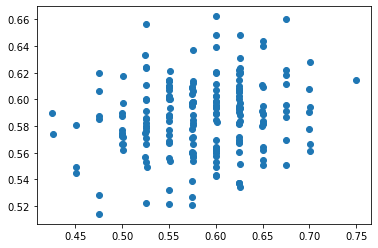

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## NGBoost - LinCV

In [33]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=lin, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

[iter 0] loss=-1.4845 val_loss=0.0000 scale=0.5000 norm=0.2465
[iter 5] loss=-1.5363 val_loss=0.0000 scale=0.5000 norm=0.2239
[iter 10] loss=-1.5550 val_loss=0.0000 scale=0.5000 norm=0.2202
[iter 15] loss=-1.5639 val_loss=0.0000 scale=0.2500 norm=0.1109
[iter 20] loss=-1.5662 val_loss=0.0000 scale=0.2500 norm=0.1111
[iter 25] loss=-1.5674 val_loss=0.0000 scale=0.0625 norm=0.0278

Test R^2: -0.101
Test RMSE: 0.062 units
Test MAE: 0.050 units


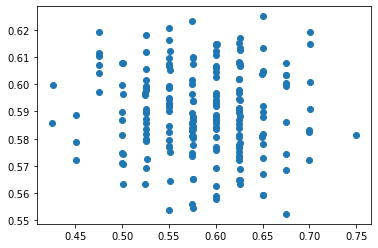

In [34]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [35]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))


Test R^2: 0.035
Test RMSE: 0.058 units
Test MAE: 0.047 units


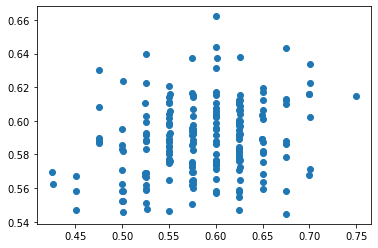

In [36]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))